In [11]:
#Imports
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import time
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from ipywidgets import interact, Dropdown


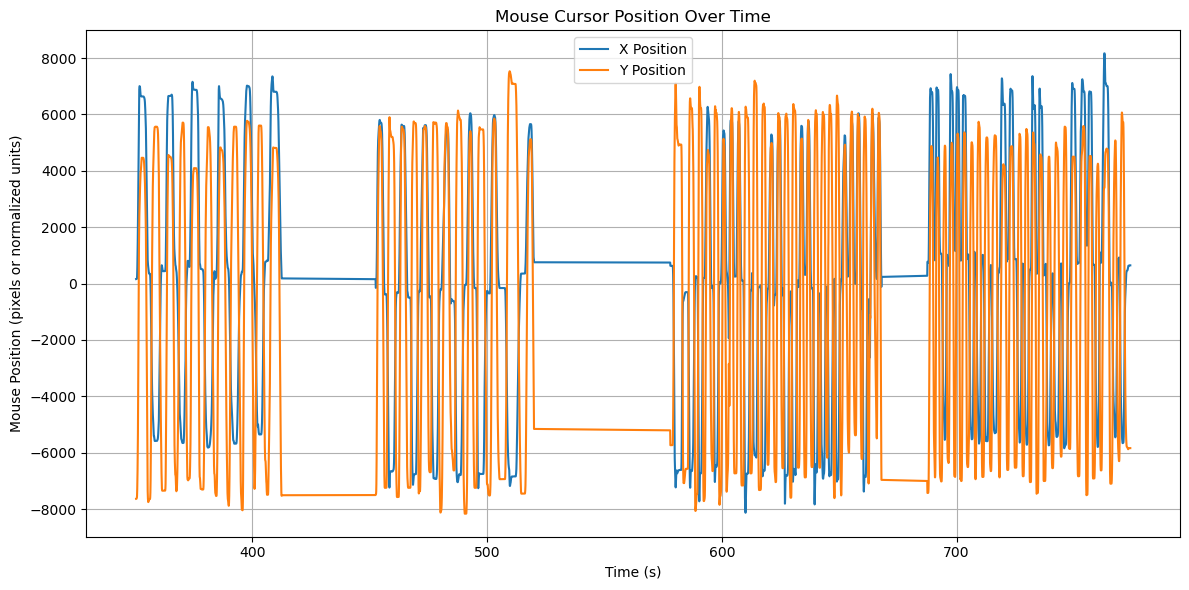

In [12]:
#Plot mouse position across time
# Load the .mat file
mat = scipy.io.loadmat('/data/courses/2025/class_bme526spring2025_bgreger/taobeng/delta_reach_20080724-111450-001_Processed.mat')

# Extract the relevant variables
mouse_position = mat['mouse_position']  # shape: [91801 x 2]
time_base = mat['time_base'].squeeze()  # shape: [91801]

# Sanity check for matching dimensions
assert mouse_position.shape[0] == time_base.shape[0], "Mismatch in time and position data length"

# Plot X and Y positions over time
plt.figure(figsize=(12, 6))
plt.plot(time_base, mouse_position[:, 0], label='X Position')
plt.plot(time_base, mouse_position[:, 1], label='Y Position')
plt.xlabel('Time (s)')
plt.ylabel('Mouse Position (pixels or normalized units)')
plt.title('Mouse Cursor Position Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


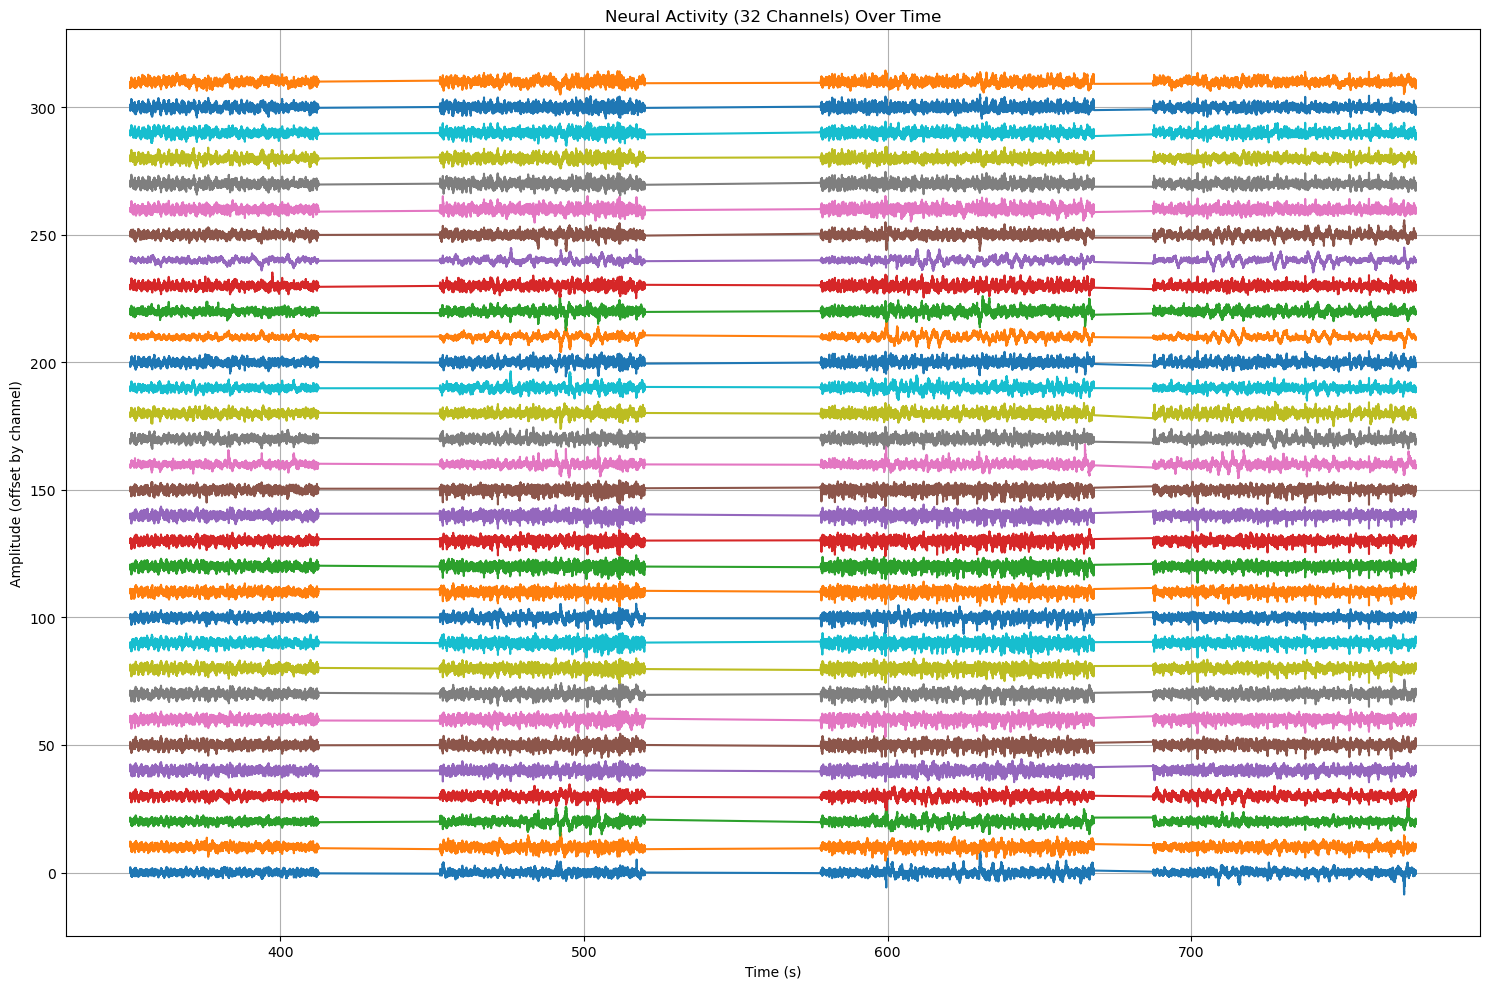

In [13]:
## Plot Neural Activity over time across all 32 Channels
# Extract variables
neural_data = mat['neural_data_pro']      # shape: (91801, 32)
time_base = mat['time_base'].squeeze()    # shape: (91801,)

# Optional: Normalize each channel for visualization
neural_data_z = (neural_data - np.mean(neural_data, axis=0)) / np.std(neural_data, axis=0)

# Plot all 32 channels
plt.figure(figsize=(15, 10))
offset = 10  # Vertical offset to separate traces visually

for i in range(32):
    plt.plot(time_base, neural_data_z[:, i] + i * offset, label=f'Ch {i+1}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (offset by channel)')
plt.title('Neural Activity (32 Channels) Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


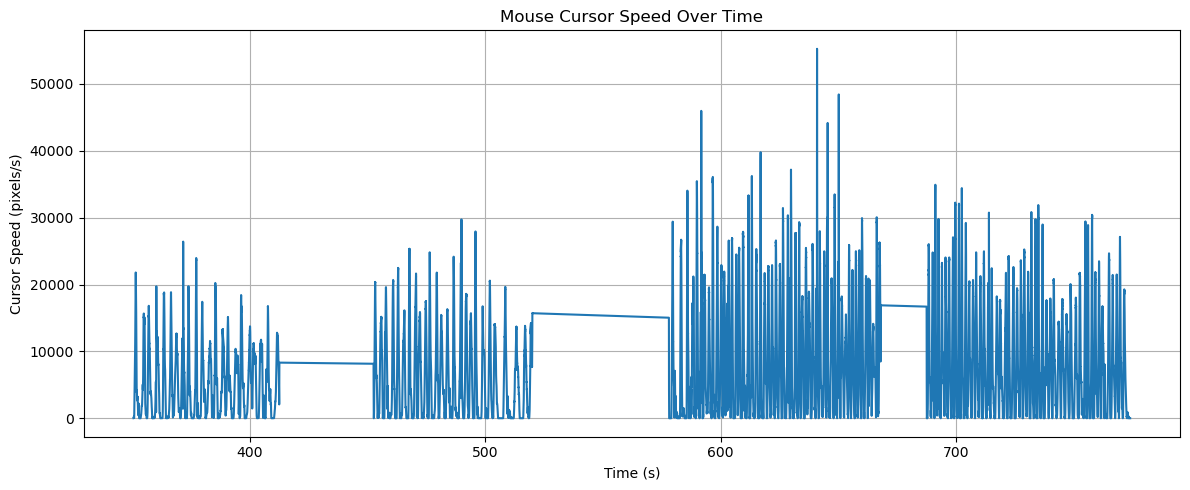

In [14]:
#Plot Mouse Cursor Speed Over Time which can indicate reaction speed of subject

# Compute velocity (dx/dt and dy/dt)
dx = np.gradient(mouse_position[:, 0], time_base)
dy = np.gradient(mouse_position[:, 1], time_base)
speed = np.sqrt(dx**2 + dy**2)

# Plot speed
plt.figure(figsize=(12, 5))
plt.plot(time_base, speed)
plt.xlabel('Time (s)')
plt.ylabel('Cursor Speed (pixels/s)')
plt.title('Mouse Cursor Speed Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()



In [15]:
##Print out neural data/mouse data input-output pairs
neural_data = mat['neural_data_pro']        # shape: (91801, 32)
mouse_position = mat['mouse_position']      # shape: (91801, 2)

# Parameters
window_size = 100     # number of timepoints in each input segment
stride = 10           # how far to slide the window (smaller = more data)

# Create input-output pairs
X = []
y = []

for i in range(0, len(neural_data) - window_size, stride):
    segment = neural_data[i:i + window_size, :]         # shape: (100, 32)
    target_pos = mouse_position[i + window_size]        # shape: (2,)
    
    X.append(segment.flatten())  # shape: (100*32,)
    y.append(target_pos)

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}  → input (neural windows)")
print(f"y shape: {y.shape}  → target mouse positions")


X shape: (9171, 3200)  → input (neural windows)
y shape: (9171, 2)  → target mouse positions


In [16]:
### 🔍 Visualizing a Neural Input Window and Corresponding Mouse Target Position
# Use the slider to select a neural window to see the 2D mouse cursor position it maps to. See spectogram as well.

# --- Interactive Plot Function ---
def visualize_sample(sample_idx):
    neural_sample = X[sample_idx].reshape(window_size, 32)
    mouse_target = y[sample_idx]

    plt.figure(figsize=(10, 5))
    plt.imshow(neural_sample.T, aspect='auto', cmap='plasma')
    plt.title(f"Neural Input Window (Sample #{sample_idx})")
    plt.xlabel('Time (100 points)')
    plt.ylabel('Channel (32)')
    plt.colorbar(label='Signal Amplitude')
    plt.tight_layout()
    plt.show()

    print(f"🎯 Target Mouse Position for this input:")
    print(f"   x = {mouse_target[0]:.2f},   y = {mouse_target[1]:.2f}")

# --- Create and Display Widget ---
slider = widgets.IntSlider(
    value=500,
    min=0,
    max=X.shape[0] - 1,
    step=1,
    description='Sample Index:',
    continuous_update=False
)

# display(slider)
widgets.interact(visualize_sample, sample_idx=slider)


interactive(children=(IntSlider(value=500, continuous_update=False, description='Sample Index:', max=9170), Ou…

<function __main__.visualize_sample(sample_idx)>

Epoch 1/50
92/92 [==============================] - 4s 28ms/step - loss: 0.1432 - mae: 0.2924 - val_loss: 0.0855 - val_mae: 0.2507 - lr: 0.0010
Epoch 2/50
92/92 [==============================] - 2s 22ms/step - loss: 0.0781 - mae: 0.2356 - val_loss: 0.0710 - val_mae: 0.2241 - lr: 0.0010
Epoch 3/50
92/92 [==============================] - 2s 23ms/step - loss: 0.0672 - mae: 0.2160 - val_loss: 0.0629 - val_mae: 0.2091 - lr: 0.0010
Epoch 4/50
92/92 [==============================] - 2s 24ms/step - loss: 0.0602 - mae: 0.2014 - val_loss: 0.0561 - val_mae: 0.1919 - lr: 0.0010
Epoch 5/50
92/92 [==============================] - 2s 25ms/step - loss: 0.0538 - mae: 0.1862 - val_loss: 0.0518 - val_mae: 0.1802 - lr: 0.0010
Epoch 6/50
92/92 [==============================] - 2s 22ms/step - loss: 0.0477 - mae: 0.1704 - val_loss: 0.0465 - val_mae: 0.1675 - lr: 0.0010
Epoch 7/50
92/92 [==============================] - 2s 22ms/step - loss: 0.0431 - mae: 0.1588 - val_loss: 0.0430 - val_mae: 0.1571 - lr:

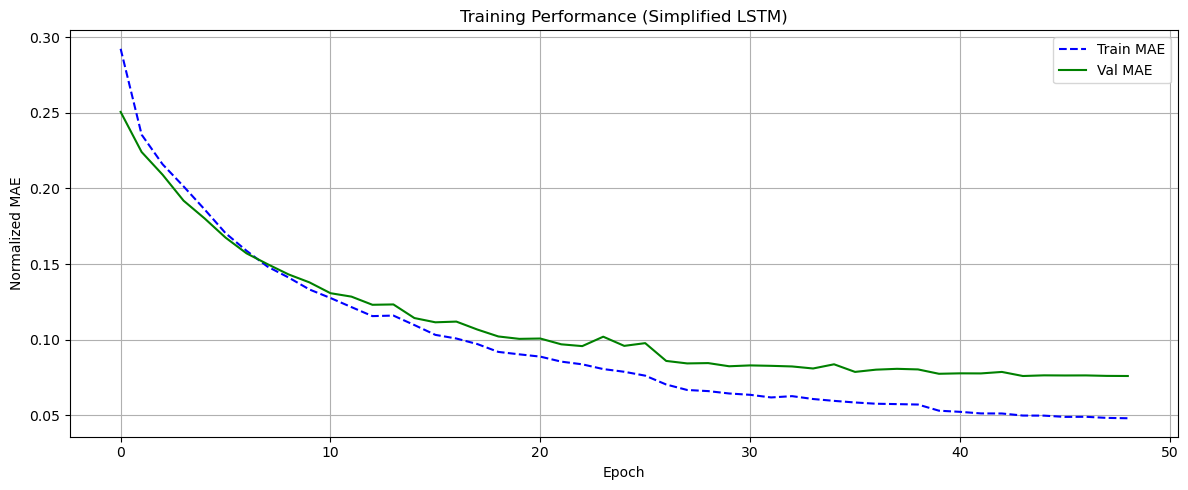

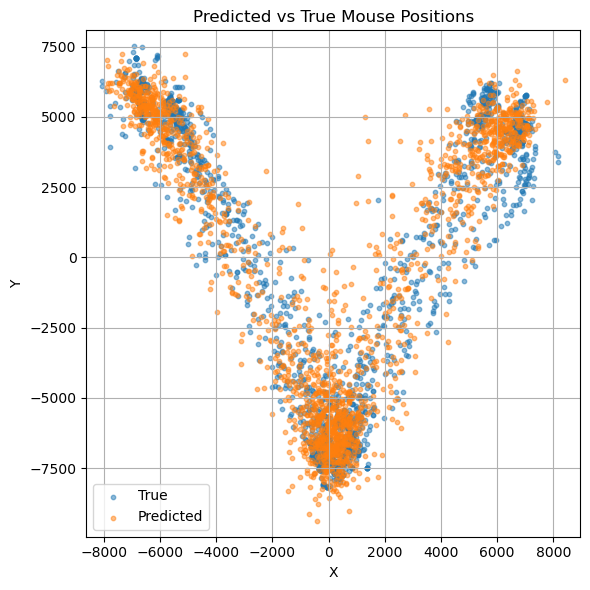

In [9]:
# --- Load .mat file ---
mat = scipy.io.loadmat('delta_reach_20080724-111450-001_Processed.mat')
neural_data = mat['neural_data_pro']
mouse_position = mat['mouse_position']
fs = int(mat['Fs_ds'].item())

# --- Parameters ---
window_size = int((100 / 1000) * fs)  # 100ms = 30 samples
stride = 10

# --- Create input/output pairs ---
X, y = [], []
for i in range(0, len(neural_data) - window_size, stride):
    X.append(neural_data[i:i+window_size, :])
    y.append(mouse_position[i + window_size // 2])  # predict midpoint

X = np.array(X)
y = np.array(y)

# --- Data Preparation ---
# --- Normalize Inputs ---
X_reshaped = X.reshape(-1, X.shape[-1])
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)

# --- Normalize outputs ---
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# --- LSTM Model ---
model = Sequential([
    Input(shape=(window_size, 32)),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dense(2)  # predict [x, y]
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

# --- Train ---
start = time.time()
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
end = time.time()

# --- Evaluate ---
loss, mae = model.evaluate(X_test, y_test, verbose=0)
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

unit_errors = np.linalg.norm(y_pred - y_true, axis=1)
mean_unit_error = unit_errors.mean()
threshold = 2500
accuracy = np.mean(unit_errors < threshold)

# --- Print results ---
print("\n📊 Model Evaluation")
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE (normalized): {mae:.4f}")
print(f"📏 Mean Distance Error: {mean_unit_error:.2f} units")
print(f"✅ Accuracy (<{threshold} units): {accuracy*100:.2f}%")
print(f"⏱ Training Time: {round(end - start, 2)} seconds")

# --- Plot MAE over time ---
plt.figure(figsize=(12, 5))
plt.plot(history.history['mae'], label='Train MAE', linestyle='--', color='blue')
plt.plot(history.history['val_mae'], label='Val MAE', linestyle='-', color='green')
plt.xlabel("Epoch")
plt.ylabel("Normalized MAE")
plt.title("Training Performance (Simplified LSTM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visualize prediction vs true ---
plt.figure(figsize=(6, 6))
plt.scatter(y_true[:, 0], y_true[:, 1], label='True', alpha=0.5, s=10)
plt.scatter(y_pred[:, 0], y_pred[:, 1], label='Predicted', alpha=0.5, s=10)
plt.title("Predicted vs True Mouse Positions")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
#This code explores how varying the number and size of LSTM layers affects the performance of this AI model trained
#to predict  mouse positions from multi-channel neural activity. Select the LSTM layer using widget
# -------------------------------------------------------------------------------------
#Comments on Accuracy
# -------------------------------------------------------------------------------------
# Changing the number and size of LSTM layers affected model performance. For example, in one instance, 
#the single LSTM layer with 64 units (LSTM_64) achieved 68.3% accuracy, which improved to 73.8% when a second layer with 32 units was added (LSTM_64_32),
#suggesting that moderate depth improves temporal pattern learning. The best performance came from LSTM_128_64, a two-layer configuration 
#with 128 and 64 units, reaching 85.19% accuracy and the lowest mean distance error, indicating strong generalization and learning capacity.
#However, adding a third LSTM layer in LSTM_128_64_32 significantly reduced accuracy to 60.35% and increased error, likely due to overfitting 
#or excess complexity. Overall, the two-layer LSTM provides the most effective mapping from neural activity to cursor movement in this task.
# ------------------------------------------------------------------------------------

# --- Load .mat file ---
mat = scipy.io.loadmat('delta_reach_20080724-111450-001_Processed.mat')
neural_data = mat['neural_data_pro']
mouse_position = mat['mouse_position']
fs = int(mat['Fs_ds'].item())

# --- Parameters ---
window_size = int((100 / 1000) * fs)  # 100ms = 30 samples
stride = 10

# --- Create input/output pairs ---
X, y = [], []
for i in range(0, len(neural_data) - window_size, stride):
    X.append(neural_data[i:i+window_size, :])
    y.append(mouse_position[i + window_size // 2])  # predict midpoint

X = np.array(X)
y = np.array(y)

# --- Normalize inputs ---
X_reshaped = X.reshape(-1, X.shape[-1])
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_reshaped).reshape(X.shape)

# --- Normalize outputs ---
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# --- Flexible model builder ---
def build_model(lstm_layers):
    model = Sequential()
    model.add(Input(shape=(window_size, 32)))

    for i, units in enumerate(lstm_layers):
        return_seq = i < len(lstm_layers) - 1
        model.add(LSTM(units, activation='relu', return_sequences=return_seq))
        model.add(Dropout(0.3))

    model.add(Dense(32, activation='relu'))
    model.add(Dense(2))  # Output [x, y]
    return model

# --- LSTM configurations ---
options = {
    'LSTM_64': [64],
    'LSTM_64_32': [64, 32],
    'LSTM_128_64': [128, 64],
    'LSTM_128_64_32': [128, 64, 32]
}

# --- Training & evaluation pipeline ---
def train_with_architecture(architecture):
    print(f"\n🧪 Training model: {architecture}")
    lstm_layers = options[architecture]

    model = build_model(lstm_layers)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3, min_lr=1e-5, verbose=0)

    start = time.time()
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    end = time.time()

    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    y_pred = scaler_y.inverse_transform(model.predict(X_test))
    y_true = scaler_y.inverse_transform(y_test)

    unit_errors = np.linalg.norm(y_pred - y_true, axis=1)
    mean_unit_error = unit_errors.mean()
    accuracy = np.mean(unit_errors < 2500)

    print(f"Test Loss: {loss:.4f}")
    print(f"Test MAE (normalized): {mae:.4f}")
    print(f"📏 Mean Distance Error: {mean_unit_error:.2f} units")
    print(f"✅ Accuracy (<2500 units): {accuracy * 100:.2f}%")
    print(f"⏱ Training Time: {round(end - start, 2)} sec")

    # --- Plot prediction vs truth ---
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true[:, 0], y_true[:, 1], label='True', alpha=0.5, s=10)
    plt.scatter(y_pred[:, 0], y_pred[:, 1], label='Predicted', alpha=0.5, s=10)
    plt.title(f"Predicted vs True Mouse Positions ({architecture})")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# --- Interactive UI ---

interact(
    train_with_architecture,
    architecture=Dropdown(
        options=list(options.keys()),
        description='LSTM Layers:'
    )
)


interactive(children=(Dropdown(description='LSTM Layers:', options=('LSTM_64', 'LSTM_64_32', 'LSTM_128_64', 'L…

<function __main__.train_with_architecture(architecture)>